In [1]:
# Bibliotecas
import eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from joblib import Parallel, delayed
from itertools import product
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Função para mostrar os resultados
def results(y_test, y_pred):
    print(f"R²: {r2_score(y_test, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")

    plt.figure(figsize=(16, 2))
    plt.plot(y_test, label='Teste')
    plt.plot(y_pred, label='Predição')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True)
    plt.xlabel('Ano')
    plt.ylabel('Cota (cm)')
    plt.legend()
    plt.show()

In [3]:
# Propondo arquiteturas de MLP para os testes 2, 3 e 4
hidden_layers = [(20, 20), (25, 15), (30, 15), (30, 30)]
f_activation = ['relu', 'identity', 'tanh']
solvers = ['adam', 'sgd']
learning_rate_init = [0.001, 0.005, 0.01]

grid = list(product(hidden_layers, f_activation, solvers, learning_rate_init))

### Teste 1
Aplicando o método usado no HidroPrev ASAC23 com mais dados

In [2]:
dados_manaus = eda.data_processing('Cotas extraidas', '1903-01-01', '2025-05-31', ['dados_diarios_estacao_14990000.csv'])
dados_manaus

,14990000
Data,
1903-01-01,1914.0
1903-01-02,1921.0
1903-01-03,1924.0
1903-01-04,1926.0
1903-01-05,1929.0
...,...
2025-05-27,2847.0
2025-05-28,2849.0
2025-05-29,2852.0


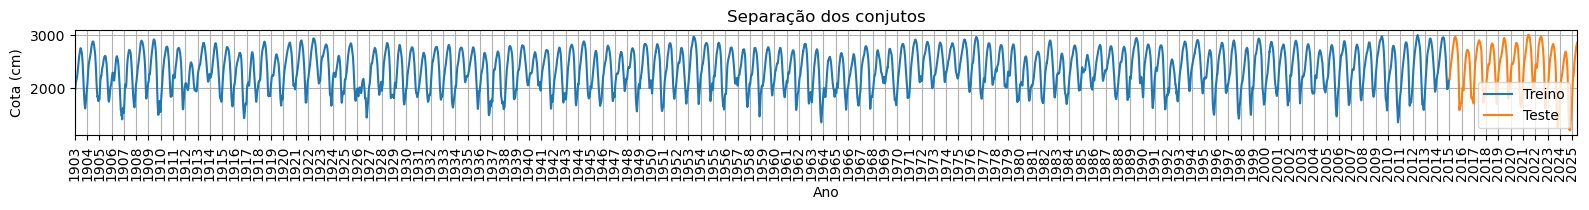

In [3]:
# Separação do conjunto
treino = dados_manaus[:'2014-12-31']
teste = dados_manaus['2015-01-01':]

plt.figure(figsize=(16, 2))
plt.plot(treino['14990000'])
plt.plot(teste['14990000'])
plt.legend(['Treino', 'Teste'])
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.xticks(rotation=90)
plt.xlim(dados_manaus.index[0], dados_manaus.index[-1])
plt.tight_layout()
plt.title('Separação dos conjutos')
plt.show()

In [4]:
# # Criação de batches
window_length = 365
shifts = np.arange(1,window_length+1)
# Create a dictionary of time-shifted data
x_shifts = {'lag_{}'.format(ii): treino['14990000'].shift(ii) for ii in shifts}
# Convert the shifts into a dataframe
x_shifts = pd.DataFrame(x_shifts)
x_shifts.fillna(0, inplace=True)

In [5]:
def pred_cota_teste1(treino, modelo):
    test_predictions = []
    first_eval_batch = treino['14990000'][-window_length:].values
    current_batch = first_eval_batch.reshape((1, window_length))

    for i in range(len(teste)):
        current_pred = modelo.predict(current_batch)[0]
        test_predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:], [[current_pred]], axis=1)
    
    return test_predictions

#### MLP

In [7]:
def run_iteration(x_shifts, treino, teste, window_length):
    mlp = MLPRegressor(hidden_layer_sizes=(11, 11), max_iter=1000, early_stopping=True, n_iter_no_change=50)
    mlp.fit(x_shifts.iloc[window_length:].values, treino['14990000'][window_length:].values)

    test_predictions = pred_cota_teste1(treino, mlp)

    y_pred = pd.DataFrame(test_predictions, index=teste['14990000'].index)
    r2 = r2_score(teste['14990000'], y_pred)

    return r2, y_pred

# Executa em paralelo
resultados = Parallel(n_jobs=-1)(
    delayed(run_iteration)(x_shifts, treino, teste, window_length) for _ in range(100)
)

# Seleciona o melhor resultado
best_r2, best_y_pred = max(resultados, key=lambda x: x[0])

R²: 0.6301
MSE: 70110.5302
RMSE: 264.7839
MAE: 189.0154


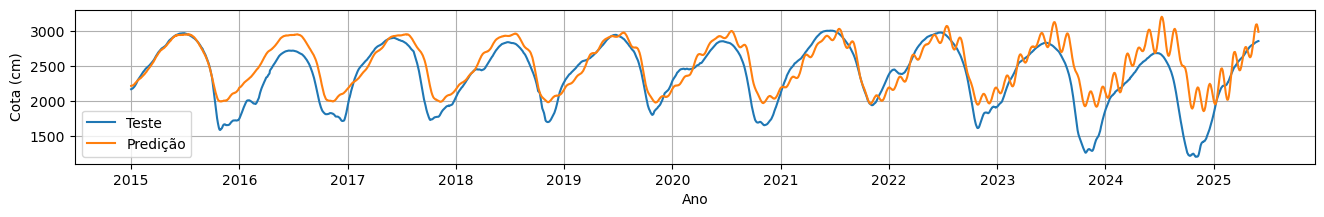

In [8]:
results(teste['14990000'], best_y_pred)

#### Random Forest

R²: 0.6285
MSE: 70417.1994
RMSE: 265.3624
MAE: 187.1404


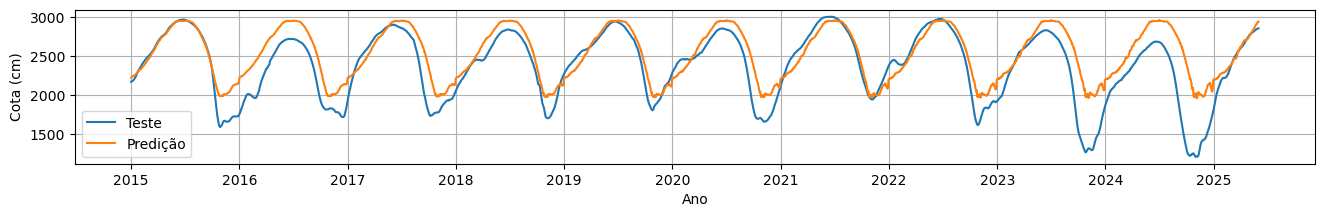

In [11]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(x_shifts.iloc[window_length:], treino['14990000'][window_length:])
rf_test_predictions = pred_cota_teste1(treino, rf)

rf_y_pred = pd.DataFrame(rf_test_predictions)
rf_y_pred.index = teste['14990000'].index

results(teste['14990000'], rf_y_pred)

##### SVR

R²: 0.5088
MSE: 93098.3680
RMSE: 305.1203
MAE: 223.8508


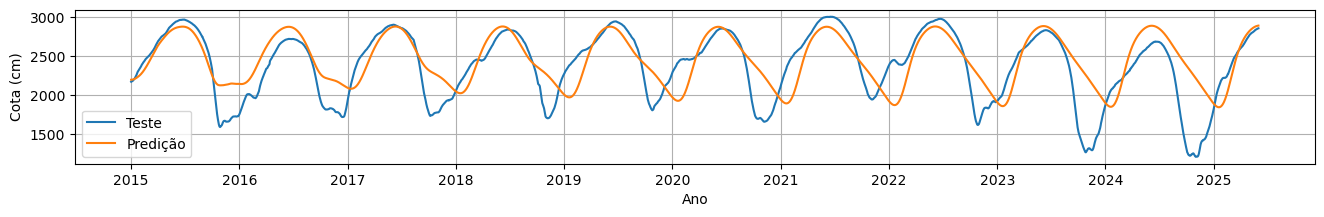

In [12]:
svr = SVR()

svr.fit(x_shifts.iloc[window_length:], treino['14990000'][window_length:])
svr_test_predictions = pred_cota_teste1(treino, svr)

svr_y_pred = pd.DataFrame(svr_test_predictions)
svr_y_pred.index = teste['14990000'].index

results(teste['14990000'], svr_y_pred)

### Teste 2

Prever cota da estação jusante usando as cotas das estações montantes. Apenas MLP

In [4]:
path = 'Cotas extraidas'
arquivos = [
    'dados_diarios_estacao_14110000.csv',
    'dados_diarios_estacao_14420000.csv',
    'dados_diarios_estacao_14480002.csv',
    'dados_diarios_estacao_14840000.csv',
    'dados_diarios_estacao_14990000.csv'
]
dados = eda.data_processing(path, '1985-01-01', '2020-12-31', arquivos)
dados

,14110000,14420000,14480002,14840000,14990000
Data,,,,,
1985-01-01,1766.0,737.0,409.0,669.0,2169.0
1985-01-02,1771.0,760.0,411.0,677.0,2178.0
1985-01-03,1774.0,769.0,413.0,681.0,2186.0
1985-01-04,1773.0,783.0,416.0,685.0,2194.0
1985-01-05,1769.0,788.0,427.0,691.0,2201.0
...,...,...,...,...,...
2020-12-27,1711.0,679.0,477.0,589.0,2062.0
2020-12-28,1718.0,689.0,480.0,597.0,2072.0
2020-12-29,1721.0,698.0,482.0,603.0,2080.0


Não será usado todas as estações do fluxo principal da bacia do Rio Negro, pois nem todas possuem dados suficientes.

In [5]:
eda.cross_corr(dados, '14990000')

Estação 14110000: Melhor lag = 23; Correlação = 0.4433
Estação 14420000: Melhor lag = 20; Correlação = 0.5914
Estação 14480002: Melhor lag = 12; Correlação = 0.7381
Estação 14840000: Melhor lag = 5; Correlação = 0.8830


Com mais dados, mais preciso será o melhor lag.\
Com dados até o final de 2020, o melhor lag das estações 1484000 e 14420000 são 5 e 20 respectivamente\
Com dados até o final de 2024, o melhor lag das mesmas estações são 4 e 19.

Será usado os dados até o final de 2020 com os lags obtidos com os dados indo até final de 2024, para comparar com os resultados do teste 3, em que serão usados índices de anomalias do El Niño, no entanto, os dados vão até o final de 2020.

In [6]:
x_shifts = {
    '14110000_lag-23': dados['14110000'].shift(23),
    '14420000_lag-19': dados['14420000'].shift(19),
    '14480002_lag-12': dados['14480002'].shift(12),
    '14840000_lag-4': dados['14840000'].shift(4)
}

x_shifts = pd.DataFrame(x_shifts)
x_shifts.fillna(0, inplace=True)

In [7]:
x_train, y_train = x_shifts['1986-01-01':'2014-12-31'], dados['14990000']['1986-01-01':'2014-12-31']
x_test, y_test = x_shifts['2015-01-01':], dados['14990000']['2015-01-01':]

In [8]:
def train_iter(x_train, y_train, x_test, y_test, arch):
    # Normalização dos dados
    x_scaler = MinMaxScaler()
    x_train_scaled = x_scaler.fit_transform(x_train)
    x_test_scaled = x_scaler.transform(x_test)

    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1)).ravel()
    
    # MLP
    mlp = MLPRegressor(
        hidden_layer_sizes=arch[0],
        activation=arch[1],
        solver=arch[2],
        max_iter=4000,
        learning_rate_init=arch[3],
        early_stopping=True,
        n_iter_no_change=50,
        verbose=False
    )
    mlp.fit(x_train_scaled, y_train_scaled)

    # Prever e desnormalizar
    y_pred = mlp.predict(x_test_scaled)
    y_pred_df = pd.DataFrame(y_pred, index=y_test.index)
    y_pred_df_inv = y_scaler.inverse_transform(y_pred_df)
    

    # Calcula o Coeficiente de Determinação R²
    r2 = r2_score(y_test, y_pred_df_inv)

    return r2, y_pred_df_inv, mlp

In [9]:
resultados_detalhados = []

for i, model in enumerate(grid):
    # Executa em paralelo 100 instâncias de cada modelo
    print(f"Modelo {i+1}/{len(grid)}: {model}")
    resultados = Parallel(n_jobs=-1)(
        delayed(train_iter)(x_train, y_train, x_test, y_test, model) for _ in range(100)
    )

    # Seleciona o melhor resultado
    best_r2, best_y_pred, best_mlp = max(resultados, key=lambda x: x[0])
    r2s = [r2[0] for r2 in resultados]
    r2_mean = np.mean(r2s)
    r2_std = np.std(r2s)

    # Guarda as informações do modelo e a melhor previsão em um dicionário
    resultados_detalhados.append({
        'modelo': model,
        'best_r2': best_r2,
        'r2_mean': r2_mean,
        'r2_std': r2_std,
        'best_pred': best_y_pred
    })

# Transforma o dicionário em um DataFrame
resultados_df = pd.DataFrame(resultados_detalhados)

# Pega o modelo com a melhor média R² score
best_model = resultados_df.loc[resultados_df.r2_mean.idxmax()]
best_model

Modelo 1/72: ((20, 20), 'relu', 'adam', 0.001)
Modelo 2/72: ((20, 20), 'relu', 'adam', 0.005)
Modelo 3/72: ((20, 20), 'relu', 'adam', 0.01)
Modelo 4/72: ((20, 20), 'relu', 'sgd', 0.001)
Modelo 5/72: ((20, 20), 'relu', 'sgd', 0.005)
Modelo 6/72: ((20, 20), 'relu', 'sgd', 0.01)
Modelo 7/72: ((20, 20), 'identity', 'adam', 0.001)
Modelo 8/72: ((20, 20), 'identity', 'adam', 0.005)
Modelo 9/72: ((20, 20), 'identity', 'adam', 0.01)
Modelo 10/72: ((20, 20), 'identity', 'sgd', 0.001)
Modelo 11/72: ((20, 20), 'identity', 'sgd', 0.005)
Modelo 12/72: ((20, 20), 'identity', 'sgd', 0.01)
Modelo 13/72: ((20, 20), 'tanh', 'adam', 0.001)
Modelo 14/72: ((20, 20), 'tanh', 'adam', 0.005)
Modelo 15/72: ((20, 20), 'tanh', 'adam', 0.01)
Modelo 16/72: ((20, 20), 'tanh', 'sgd', 0.001)
Modelo 17/72: ((20, 20), 'tanh', 'sgd', 0.005)
Modelo 18/72: ((20, 20), 'tanh', 'sgd', 0.01)
Modelo 19/72: ((25, 15), 'relu', 'adam', 0.001)
Modelo 20/72: ((25, 15), 'relu', 'adam', 0.005)
Modelo 21/72: ((25, 15), 'relu', 'adam',

modelo                             ((25, 15), tanh, sgd, 0.01)
best_r2                                               0.958723
r2_mean                                               0.955454
r2_std                                                0.001159
best_pred    [[2046.7983207011414], [2064.9689972364345], [...
Name: 35, dtype: object

R²: 0.9587
MSE: 6517.4323
RMSE: 80.7306
MAE: 60.7480


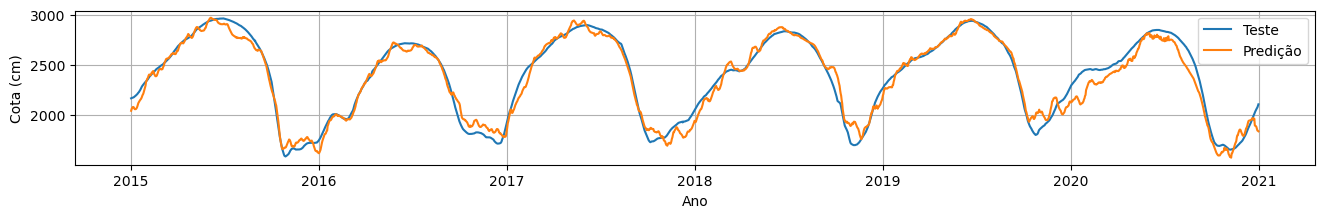

In [10]:
best_pred = pd.DataFrame(best_model['best_pred'], index=y_test.index)
results(y_test, best_pred)

### Teste 3
Usando cotas montantes + anomalias de El Niño para prever a cota jusante

In [11]:
path = 'Cotas extraidas'
arquivos = [
    'dados_diarios_estacao_14110000.csv',
    'dados_diarios_estacao_14420000.csv',
    'dados_diarios_estacao_14480002.csv',
    'dados_diarios_estacao_14840000.csv',
    'dados_diarios_estacao_14990000.csv'
]
dados2 = eda.data_processing(path, '1985-01-01', '2020-12-31', arquivos)

In [12]:
nino3 = pd.read_csv('El Nino - indices/sst_nino3.csv', sep=';')
nino34 = pd.read_csv('El Nino - indices/sst_nino34.csv', sep=';')

In [13]:
nino3['time'] = pd.to_datetime(nino3['time'])
nino3.index = nino3['time']
nino3.drop(columns=['time'], inplace=True)

nino34['time'] = pd.to_datetime(nino34['time'])
nino34.index = nino34['time']
nino34.drop(columns=['time'], inplace=True)

In [14]:
dados2['El Nino 3'] = nino3['sst']
dados2['El nino 34'] = nino34['sst']
dados2

,14110000,14420000,14480002,14840000,14990000,El Nino 3,El nino 34
Data,,,,,,,
1985-01-01,1766.0,737.0,409.0,669.0,2169.0,-1.130554,-1.003260
1985-01-02,1771.0,760.0,411.0,677.0,2178.0,-1.118706,-0.972396
1985-01-03,1774.0,769.0,413.0,681.0,2186.0,-1.004945,-0.960776
1985-01-04,1773.0,783.0,416.0,685.0,2194.0,-0.933292,-0.977119
1985-01-05,1769.0,788.0,427.0,691.0,2201.0,-0.936055,-1.000219
...,...,...,...,...,...,...,...
2020-12-27,1711.0,679.0,477.0,589.0,2062.0,-0.695351,-0.900767
2020-12-28,1718.0,689.0,480.0,597.0,2072.0,-0.639939,-0.881045
2020-12-29,1721.0,698.0,482.0,603.0,2080.0,-0.601540,-0.874717


In [15]:
x_shifts = {
    'El Nino34_lag-190': dados2['El nino 34'].shift(190),
    'El Nino 3_lag-178': dados2['El Nino 3'].shift(178),
    '14110000_lag-23': dados2['14110000'].shift(23),
    '14420000_lag-19': dados2['14420000'].shift(19),
    '14480002_lag-12': dados2['14480002'].shift(12),
    '14840000_lag-4': dados2['14840000'].shift(4)
}

x_shifts = pd.DataFrame(x_shifts)
x_shifts.fillna(0, inplace=True)
x_shifts

,El Nino34_lag-190,El Nino 3_lag-178,14110000_lag-23,14420000_lag-19,14480002_lag-12,14840000_lag-4
Data,,,,,,
1985-01-01,0.000000,0.000000,0.0,0.0,0.0,0.0
1985-01-02,0.000000,0.000000,0.0,0.0,0.0,0.0
1985-01-03,0.000000,0.000000,0.0,0.0,0.0,0.0
1985-01-04,0.000000,0.000000,0.0,0.0,0.0,0.0
1985-01-05,0.000000,0.000000,0.0,0.0,0.0,669.0
...,...,...,...,...,...,...
2020-12-27,-0.373382,-0.367293,1683.0,704.0,461.0,580.0
2020-12-28,-0.350001,-0.320890,1705.0,708.0,463.0,582.0
2020-12-29,-0.255234,-0.312356,1721.0,709.0,465.0,582.0


In [16]:
x_train, y_train = x_shifts['1986-01-01':'2014-12-31'], dados2['14990000']['1986-01-01':'2014-12-31']
x_test, y_test = x_shifts['2015-01-01':], dados2['14990000']['2015-01-01':]

In [17]:
# mlp = MLPRegressor(
#     hidden_layer_sizes=(30, 30),
#     activation='relu',
#     max_iter=4000,
#     early_stopping=True,
#     n_iter_no_change=50,
#     shuffle=False
# )

# mlp.fit(x_train_scaled, y_train_scaled)

# test_predictions = mlp.predict(x_test_scaled)
# y_pred = pd.DataFrame(test_predictions, index=y_test.index)

In [18]:
resultados_detalhados2 = []

for i, model in enumerate(grid):
    print(f"Modelo {i+1}/{len(grid)}: {model}")
    resultados = Parallel(n_jobs=-1)(
        delayed(train_iter)(x_train, y_train, x_test, y_test, model) for _ in range(100)
    )

    # Seleciona o melhor resultado
    best_r2, best_y_pred, best_mlp = max(resultados, key=lambda x: x[0])
    r2s = [r2[0] for r2 in resultados]
    r2_mean = np.mean(r2s)
    r2_std = np.std(r2s)

    resultados_detalhados2.append({
        'modelo': model,
        'best_r2': best_r2,
        'r2_mean': r2_mean,
        'r2_std': r2_std,
        'best_pred': best_y_pred
    })

resultados_df2 = pd.DataFrame(resultados_detalhados2)
best_model2 = resultados_df2.loc[resultados_df2.r2_mean.idxmax()]
best_model2

Modelo 1/72: ((20, 20), 'relu', 'adam', 0.001)
Modelo 2/72: ((20, 20), 'relu', 'adam', 0.005)
Modelo 3/72: ((20, 20), 'relu', 'adam', 0.01)
Modelo 4/72: ((20, 20), 'relu', 'sgd', 0.001)
Modelo 5/72: ((20, 20), 'relu', 'sgd', 0.005)
Modelo 6/72: ((20, 20), 'relu', 'sgd', 0.01)
Modelo 7/72: ((20, 20), 'identity', 'adam', 0.001)
Modelo 8/72: ((20, 20), 'identity', 'adam', 0.005)
Modelo 9/72: ((20, 20), 'identity', 'adam', 0.01)
Modelo 10/72: ((20, 20), 'identity', 'sgd', 0.001)
Modelo 11/72: ((20, 20), 'identity', 'sgd', 0.005)
Modelo 12/72: ((20, 20), 'identity', 'sgd', 0.01)
Modelo 13/72: ((20, 20), 'tanh', 'adam', 0.001)
Modelo 14/72: ((20, 20), 'tanh', 'adam', 0.005)
Modelo 15/72: ((20, 20), 'tanh', 'adam', 0.01)
Modelo 16/72: ((20, 20), 'tanh', 'sgd', 0.001)
Modelo 17/72: ((20, 20), 'tanh', 'sgd', 0.005)
Modelo 18/72: ((20, 20), 'tanh', 'sgd', 0.01)
Modelo 19/72: ((25, 15), 'relu', 'adam', 0.001)
Modelo 20/72: ((25, 15), 'relu', 'adam', 0.005)
Modelo 21/72: ((25, 15), 'relu', 'adam',

modelo                             ((30, 15), tanh, sgd, 0.01)
best_r2                                               0.958269
r2_mean                                               0.955367
r2_std                                                0.001519
best_pred    [[2046.62283437325], [2064.402891422406], [207...
Name: 53, dtype: object

R²: 0.9583
MSE: 6589.1052
RMSE: 81.1733
MAE: 61.6365


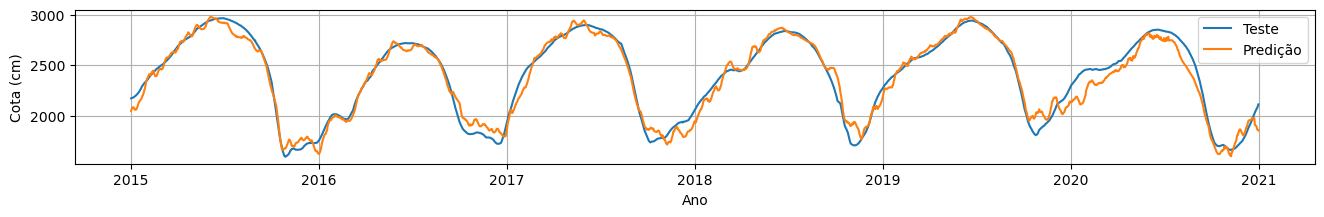

In [19]:
best_pred2 = pd.DataFrame(best_model2['best_pred'], index=y_test.index)
results(y_test, best_pred2)

### Teste 4
Cotas montantes + El Niño + Precipitação

In [20]:
path = 'Cotas extraidas'
arquivos = [
    'dados_diarios_estacao_14110000.csv',
    'dados_diarios_estacao_14420000.csv',
    'dados_diarios_estacao_14480002.csv',
    'dados_diarios_estacao_14840000.csv',
    'dados_diarios_estacao_14990000.csv'
]
dados3 = eda.data_processing(path, '1985-01-01', '2020-12-31', arquivos)

nino3 = pd.read_csv('El Nino - indices/sst_nino3.csv', sep=';')
nino34 = pd.read_csv('El Nino - indices/sst_nino34.csv', sep=';')

nino3['time'] = pd.to_datetime(nino3['time'])
nino3.index = nino3['time']
nino3.drop(columns=['time'], inplace=True)

nino34['time'] = pd.to_datetime(nino34['time'])
nino34.index = nino34['time']
nino34.drop(columns=['time'], inplace=True)

dados3['El Nino 3'] = nino3['sst']
dados3['El nino 34'] = nino34['sst']

prec = pd.read_csv('Precipitação/manaus_prec.csv', sep=';')

prec['Data'] = pd.to_datetime(prec['Data'])
prec.index = prec['Data']
prec.drop(columns=['Data'], inplace=True)

dados3['Precipitacao'] = prec['value']
dados3

,14110000,14420000,14480002,14840000,14990000,El Nino 3,El nino 34,Precipitacao
Data,,,,,,,,
1985-01-01,1766.0,737.0,409.0,669.0,2169.0,-1.130554,-1.003260,0.000000
1985-01-02,1771.0,760.0,411.0,677.0,2178.0,-1.118706,-0.972396,1.625000
1985-01-03,1774.0,769.0,413.0,681.0,2186.0,-1.004945,-0.960776,0.000000
1985-01-04,1773.0,783.0,416.0,685.0,2194.0,-0.933292,-0.977119,0.000000
1985-01-05,1769.0,788.0,427.0,691.0,2201.0,-0.936055,-1.000219,0.000000
...,...,...,...,...,...,...,...,...
2020-12-27,1711.0,679.0,477.0,589.0,2062.0,-0.695351,-0.900767,4.781250
2020-12-28,1718.0,689.0,480.0,597.0,2072.0,-0.639939,-0.881045,12.757810
2020-12-29,1721.0,698.0,482.0,603.0,2080.0,-0.601540,-0.874717,44.960940


In [21]:
x_shifts = {
    'El Nino34_lag-190': dados3['El nino 34'].shift(190),
    'El Nino 3_lag-178': dados3['El Nino 3'].shift(178),
    'Precipitacao_lag-4': dados3['Precipitacao'].shift(4),
    '14110000_lag-23': dados3['14110000'].shift(23),
    '14420000_lag-19': dados3['14420000'].shift(19),
    '14480002_lag-12': dados3['14480002'].shift(12),
    '14840000_lag-4': dados3['14840000'].shift(4)
}

x_shifts = pd.DataFrame(x_shifts)
x_shifts.fillna(0, inplace=True)
x_shifts

,El Nino34_lag-190,El Nino 3_lag-178,Precipitacao_lag-4,14110000_lag-23,14420000_lag-19,14480002_lag-12,14840000_lag-4
Data,,,,,,,
1985-01-01,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1985-01-02,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1985-01-03,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1985-01-04,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1985-01-05,0.000000,0.000000,0.000000,0.0,0.0,0.0,669.0
...,...,...,...,...,...,...,...
2020-12-27,-0.373382,-0.367293,8.390625,1683.0,704.0,461.0,580.0
2020-12-28,-0.350001,-0.320890,17.132810,1705.0,708.0,463.0,582.0
2020-12-29,-0.255234,-0.312356,0.898438,1721.0,709.0,465.0,582.0


In [22]:
x_train, y_train = x_shifts['1986-01-01':'2014-12-31'], dados3['14990000']['1986-01-01':'2014-12-31']
x_test, y_test = x_shifts['2015-01-01':], dados3['14990000']['2015-01-01':]

In [23]:
resultados_detalhados3 = []

for i, model in enumerate(grid):
    print(f"Modelo {i+1}/{len(grid)}: {model}")
    resultados = Parallel(n_jobs=-1)(
        delayed(train_iter)(x_train, y_train, x_test, y_test, model) for _ in range(100)
    )

    # Seleciona o melhor resultado
    best_r2, best_y_pred, best_mlp = max(resultados, key=lambda x: x[0])
    r2s = [r2[0] for r2 in resultados]
    r2_mean = np.mean(r2s)
    r2_std = np.std(r2s)

    resultados_detalhados3.append({
        'modelo': model,
        'best_r2': best_r2,
        'r2_mean': r2_mean,
        'r2_std': r2_std,
        'best_pred': best_y_pred
    })

resultados_df3 = pd.DataFrame(resultados_detalhados3)
best_model3 = resultados_df3.loc[resultados_df3.r2_mean.idxmax()]
best_model3

Modelo 1/72: ((20, 20), 'relu', 'adam', 0.001)
Modelo 2/72: ((20, 20), 'relu', 'adam', 0.005)
Modelo 3/72: ((20, 20), 'relu', 'adam', 0.01)
Modelo 4/72: ((20, 20), 'relu', 'sgd', 0.001)
Modelo 5/72: ((20, 20), 'relu', 'sgd', 0.005)
Modelo 6/72: ((20, 20), 'relu', 'sgd', 0.01)
Modelo 7/72: ((20, 20), 'identity', 'adam', 0.001)
Modelo 8/72: ((20, 20), 'identity', 'adam', 0.005)
Modelo 9/72: ((20, 20), 'identity', 'adam', 0.01)
Modelo 10/72: ((20, 20), 'identity', 'sgd', 0.001)
Modelo 11/72: ((20, 20), 'identity', 'sgd', 0.005)
Modelo 12/72: ((20, 20), 'identity', 'sgd', 0.01)
Modelo 13/72: ((20, 20), 'tanh', 'adam', 0.001)
Modelo 14/72: ((20, 20), 'tanh', 'adam', 0.005)
Modelo 15/72: ((20, 20), 'tanh', 'adam', 0.01)
Modelo 16/72: ((20, 20), 'tanh', 'sgd', 0.001)
Modelo 17/72: ((20, 20), 'tanh', 'sgd', 0.005)
Modelo 18/72: ((20, 20), 'tanh', 'sgd', 0.01)
Modelo 19/72: ((25, 15), 'relu', 'adam', 0.001)
Modelo 20/72: ((25, 15), 'relu', 'adam', 0.005)
Modelo 21/72: ((25, 15), 'relu', 'adam',

modelo                             ((25, 15), tanh, sgd, 0.01)
best_r2                                               0.958818
r2_mean                                               0.955328
r2_std                                                0.001427
best_pred    [[2058.901958344866], [2078.4969557058903], [2...
Name: 35, dtype: object

R²: 0.9588
MSE: 6502.3228
RMSE: 80.6370
MAE: 60.9731


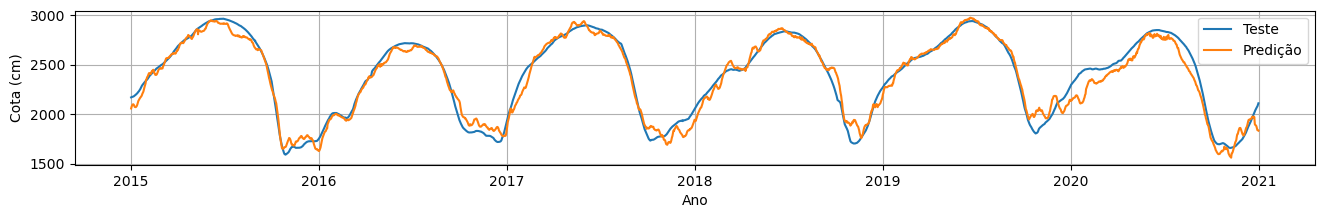

In [24]:
best_pred3 = pd.DataFrame(best_model3['best_pred'], index=y_test.index)
results(y_test, best_pred3)

### Comparação testes 2, 3 e 4

In [28]:
resultados_df.nlargest(5, 'r2_mean')

,modelo,best_r2,r2_mean,r2_std,best_pred
35,"((25, 15), tanh, sgd, 0.01)",0.958723,0.955454,0.001159,"[[2046.7983207011414], [2064.9689972364345], [..."
58,"((30, 30), relu, sgd, 0.005)",0.958444,0.955445,0.001287,"[[2061.6024148877655], [2079.0968977783127], [..."
40,"((30, 15), relu, sgd, 0.005)",0.958421,0.955405,0.001822,"[[2083.2427999082215], [2107.854259337558], [2..."
17,"((20, 20), tanh, sgd, 0.01)",0.957977,0.955358,0.001215,"[[2043.2890615223725], [2061.7103584907977], [..."
59,"((30, 30), relu, sgd, 0.01)",0.957761,0.955286,0.001244,"[[2090.6147351456375], [2109.0428194563433], [..."


In [29]:
resultados_df2.nlargest(5, 'r2_mean')

,modelo,best_r2,r2_mean,r2_std,best_pred
53,"((30, 15), tanh, sgd, 0.01)",0.958269,0.955367,0.001519,"[[2046.62283437325], [2064.402891422406], [207..."
17,"((20, 20), tanh, sgd, 0.01)",0.958343,0.955322,0.001575,"[[2066.0284662294707], [2083.6579993774258], [..."
35,"((25, 15), tanh, sgd, 0.01)",0.958252,0.955257,0.001435,"[[2054.9129981800183], [2072.9394644931335], [..."
71,"((30, 30), tanh, sgd, 0.01)",0.957962,0.954786,0.001318,"[[2043.0402795506693], [2061.0279283654813], [..."
58,"((30, 30), relu, sgd, 0.005)",0.957332,0.954570,0.001512,"[[2082.472910201798], [2099.5109469091753], [2..."


In [30]:
resultados_df3.nlargest(5, 'r2_mean')

,modelo,best_r2,r2_mean,r2_std,best_pred
35,"((25, 15), tanh, sgd, 0.01)",0.958818,0.955328,0.001427,"[[2058.901958344866], [2078.4969557058903], [2..."
53,"((30, 15), tanh, sgd, 0.01)",0.958381,0.955239,0.001371,"[[2056.650193042627], [2073.3793820951355], [2..."
17,"((20, 20), tanh, sgd, 0.01)",0.957839,0.954909,0.001409,"[[2044.463946782379], [2061.5553233192463], [2..."
58,"((30, 30), relu, sgd, 0.005)",0.957909,0.954729,0.001640,"[[2079.2916371365072], [2090.8291819657024], [..."
71,"((30, 30), tanh, sgd, 0.01)",0.958704,0.954705,0.001496,"[[2071.526383194529], [2088.068787350644], [20..."
